This notebook contains a brief illustration of the updated sky model. For details refer to Parker's thesis.

In [1]:
import numpy as np 
import astropy.units as u
# -- feasibgs --
from feasibgs import util as UT
from feasibgs import skymodel as Sky
from feasibgs import forwardmodel as FM
# -- desi -- 
import desimodel.io
import desisim.simexp

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
params = desimodel.io.load_desiparams() 
wavemin = params['ccd']['b']['wavemin']
wavemax = params['ccd']['z']['wavemax']
print('%f < lambda < %f' % (wavemin, wavemax))

waves = np.arange(wavemin, wavemax, 0.2) * u.angstrom
config = desisim.simexp._specsim_config_for_wave((waves).to('Angstrom').value, specsim_config_file='desi')
surface_brightness_dict = config.load_table(config.atmosphere.sky, 'surface_brightness', as_dict=True)

3533.000000 < lambda < 9913.000000


(0.0, 10.0)

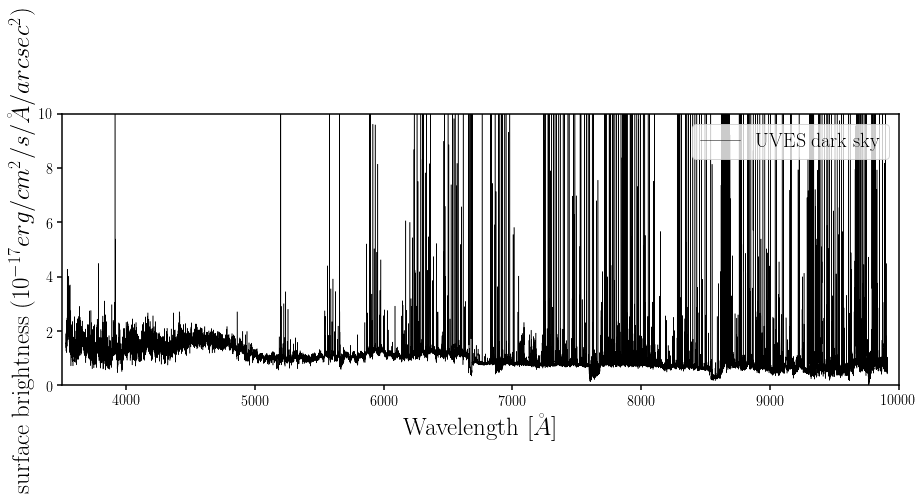

In [4]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(waves, surface_brightness_dict['dark'], c='k', lw=0.5, label='UVES dark sky')
#sub.plot(uves_sky_bright[0], uves_sky_bright[1], c='C1', lw=0.5, label='UVES bright sky')
sub.legend(loc='upper right', fontsize=20, frameon=True)
sub.set_xlabel(r'Wavelength [$\AA$]', fontsize=25)
sub.set_xlim([3500., 1.e4])
sub.set_ylabel(r"surface brightness ($10^{-17} erg/cm^{2}/s/\AA/arcsec^2$)", fontsize=25)
sub.set_ylim([0., 10.])

Above is the default dark sky surface brightness currently used in `specsim`. I _believe_ this is derived from UVES. 

In [5]:
desi = FM.SimulatorHacked(config, num_fibers=1, camera_output=True)
airmass = 1.4
alt = 42.18
sep = 69.
ill = 0.42 
desi.atmosphere.airmass = airmass
desi.atmosphere.moon.moon_phase = np.arccos(2.*ill - 1)/np.pi #moon_phase/np.pi #np.arccos(2*moonfrac-1)/np.pi
desi.atmosphere.moon.moon_zenith = (90. - alt) * u.deg
desi.atmosphere.moon.separation_angle = sep * u.deg

(0.0, 10.0)

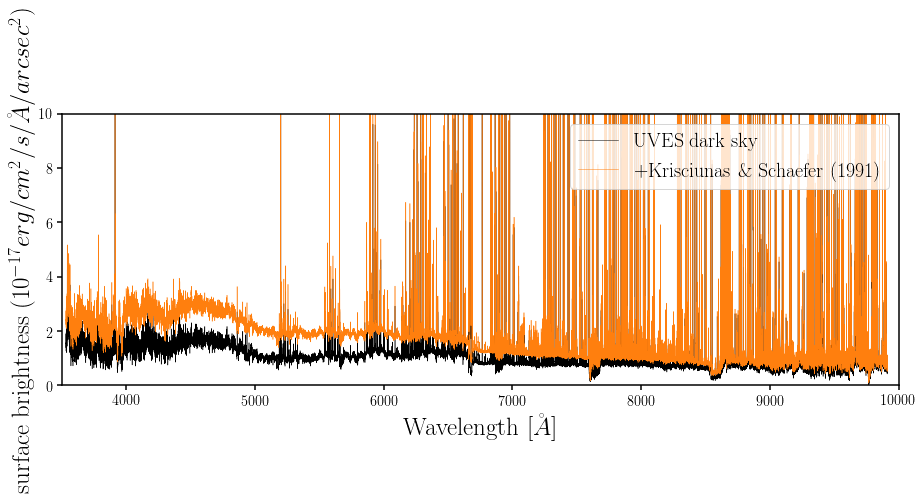

In [6]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(waves, surface_brightness_dict['dark'], 
         c='k', lw=0.5, label='UVES dark sky')
sub.plot(waves, surface_brightness_dict['dark'] + desi.atmosphere.moon.surface_brightness, 
         c='C1', lw=0.5, label=r'+Krisciunas $\&$ Schaefer (1991)')
sub.legend(loc='upper right', fontsize=20, frameon=True)
sub.set_xlabel(r'Wavelength [$\AA$]', fontsize=25)
sub.set_xlim([3500., 1.e4])
sub.set_ylabel(r"surface brightness ($10^{-17} erg/cm^{2}/s/\AA/arcsec^2$)", fontsize=25)
sub.set_ylim([0., 10.])

The `specsim` bright sky model combines the UVES dark sky with the moon model from Krisciunas & Schaefer (1991). Above is what the sky surface brightness looks like for the following sky and lunar parameters: 

- `airmass=1.4`
- moon altitude = $42.18$ degrees
- moon separation = $69.$ degrees
- moon illumination = $0.42$. This corresponds to a moon phase of $0.55$

In [7]:
fakedesi = FM.fakeDESIspec()

(0.0, 10.0)

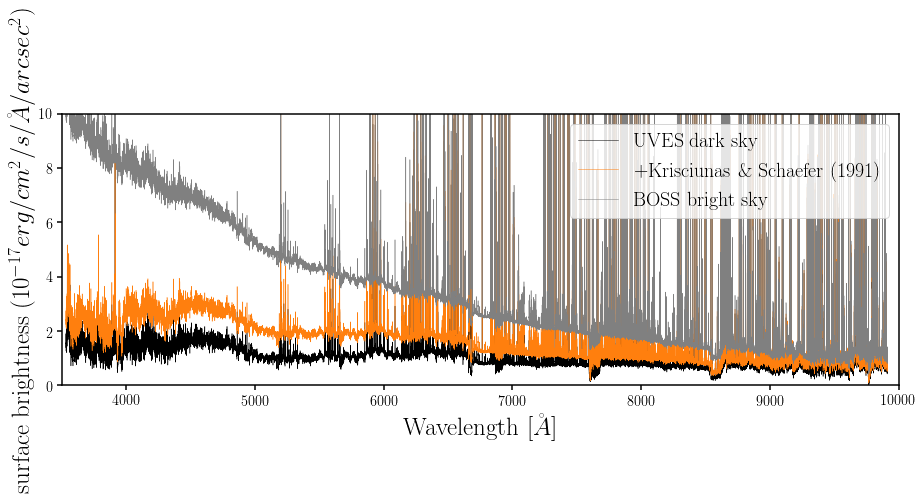

In [8]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(waves, surface_brightness_dict['dark'], 
         c='k', lw=0.5, label='UVES dark sky')
sub.plot(waves, surface_brightness_dict['dark'] + desi.atmosphere.moon.surface_brightness, 
         c='C1', lw=0.5, label=r'+Krisciunas $\&$ Schaefer (1991)')
sub.plot(waves, fakedesi._skySurfBright(waves, cond='bright'), 
         c='gray', lw=0.5, label='BOSS bright sky')
sub.legend(loc='upper right', fontsize=20, frameon=True)
sub.set_xlabel(r'Wavelength [$\AA$]', fontsize=25)
sub.set_xlim([3500., 1.e4])
sub.set_ylabel(r"surface brightness ($10^{-17} erg/cm^{2}/s/\AA/arcsec^2$)", fontsize=25)
sub.set_ylim([0., 10.])

In the previous version of `feasiBGS` the bright sky model was a fixed (_i.e._ no parameter dependence). The bright sky surface brightness was derived from some fiducial BOSS bright sky flux. Above is how it compares to the `specsim` bright sky model.

In [9]:
theta_sky = (airmass, 30., 10., 180., 4.86761390e+09, -25., 150., np.arccos(2.*ill - 1), ill, sep, alt)
sky_obj = Sky.skySpec_manual(*theta_sky)

/Users/chang/anaconda2/lib/python2.7/site-packages/feasibgs/skymodel.py:267: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  coeffs = pd.DataFrame.from_csv(f)
/Users/chang/anaconda2/lib/python2.7/site-packages/feasibgs/skymodel.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.coeffs[k] = np.array(self.coeffs[k])[self.wave_sort]


(0.0, 10.0)

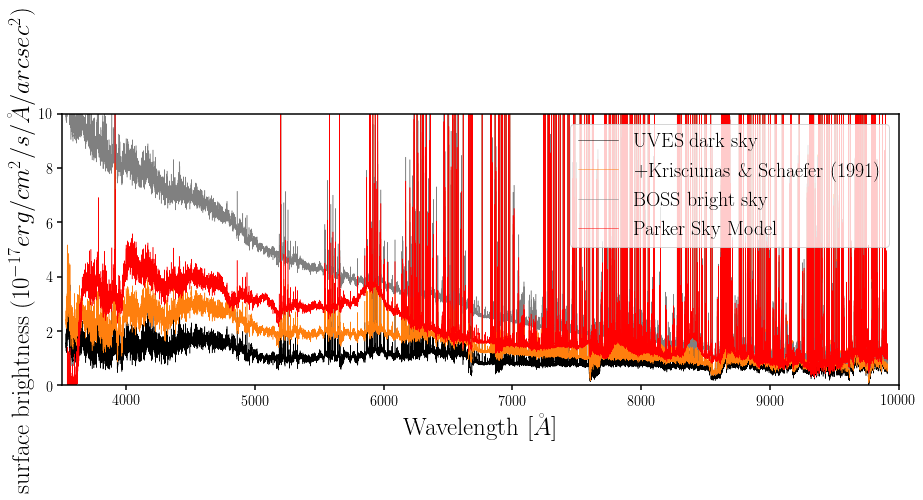

In [10]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(waves, surface_brightness_dict['dark'], 
         c='k', lw=0.5, label='UVES dark sky')
sub.plot(waves, surface_brightness_dict['dark'] + desi.atmosphere.moon.surface_brightness, 
         c='C1', lw=0.5, label=r'+Krisciunas $\&$ Schaefer (1991)')
sub.plot(waves, fakedesi._skySurfBright(waves, cond='bright'), 
         c='gray', lw=0.5, label='BOSS bright sky')
sub.plot(waves, sky_obj.surface_brightness(waves), 
         c='r', lw=0.5, label=r'Parker Sky Model')
sub.legend(loc='upper right', fontsize=20, frameon=True)
sub.set_xlabel(r'Wavelength [$\AA$]', fontsize=25)
sub.set_xlim([3500., 1.e4])
sub.set_ylabel(r"surface brightness ($10^{-17} erg/cm^{2}/s/\AA/arcsec^2$)", fontsize=25)
sub.set_ylim([0., 10.])

Here's the updated bright sky model in `feasiBGS`. The sky model depends on 11 parameters: 
- airmass 
- ecliptic latitude
- galactic latitude
- galactic longitude
- time of observation 
- sun altitude
- sun separation
- moon phase
- moon illumination 
- moon separation 
- moon altitude

Above I compare the updated `feasibGS` bright sky model to the `specsim` bright sky model and the BOSS bright sky. I use the same lunar parameters for both `feasiBGS` and `specsim` models. 

(0.0, 10.0)

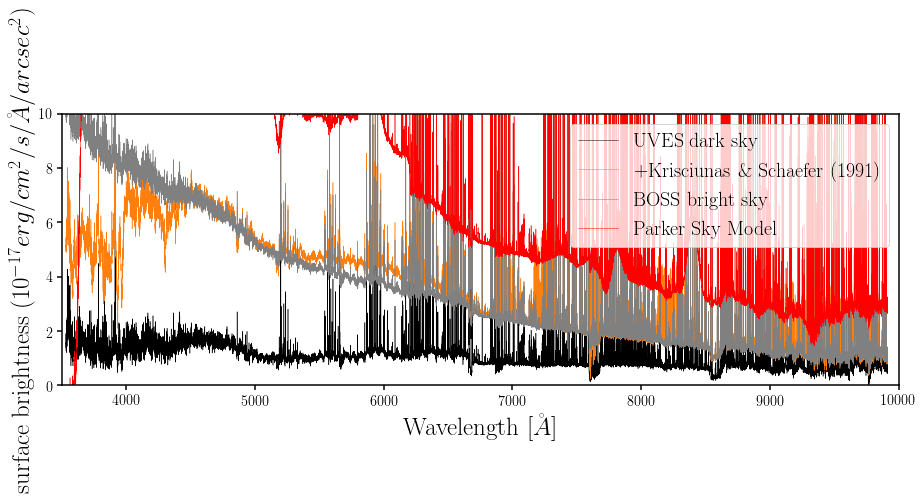

In [11]:
desi = FM.SimulatorHacked(config, num_fibers=1, camera_output=True)
airmass = 1.4
alt = 42.18
sep = 69.
ill = 0.8
desi.atmosphere.airmass = airmass
desi.atmosphere.moon.moon_phase = np.arccos(2.*ill - 1)/np.pi #moon_phase/np.pi #np.arccos(2*moonfrac-1)/np.pi
desi.atmosphere.moon.moon_zenith = (90. - alt) * u.deg
desi.atmosphere.moon.separation_angle = sep * u.deg

theta_sky = (airmass, 30., 10., 180., 4.86761390e+09, -25., 150., np.arccos(2.*ill - 1), ill, sep, alt)
sky_obj = Sky.skySpec_manual(*theta_sky)
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(waves, surface_brightness_dict['dark'], 
         c='k', lw=0.5, label='UVES dark sky')
sub.plot(waves, surface_brightness_dict['dark'] + desi.atmosphere.moon.surface_brightness, 
         c='C1', lw=0.5, label=r'+Krisciunas $\&$ Schaefer (1991)')
sub.plot(waves, fakedesi._skySurfBright(waves, cond='bright'), 
         c='gray', lw=0.5, label='BOSS bright sky')
sub.plot(waves, sky_obj.surface_brightness(waves), 
         c='r', lw=0.5, label=r'Parker Sky Model')
sub.legend(loc='upper right', fontsize=20, frameon=True)
sub.set_xlabel(r'Wavelength [$\AA$]', fontsize=25)
sub.set_xlim([3500., 1.e4])
sub.set_ylabel(r"surface brightness ($10^{-17} erg/cm^{2}/s/\AA/arcsec^2$)", fontsize=25)
sub.set_ylim([0., 10.])

Above is the same comparison but for a different set of lunar parameters: 
- airmass = `1.4`
- moon alt = `42.18`
- moon sep = `69.`
- moon ill = `0.8`

(0.0, 10.0)

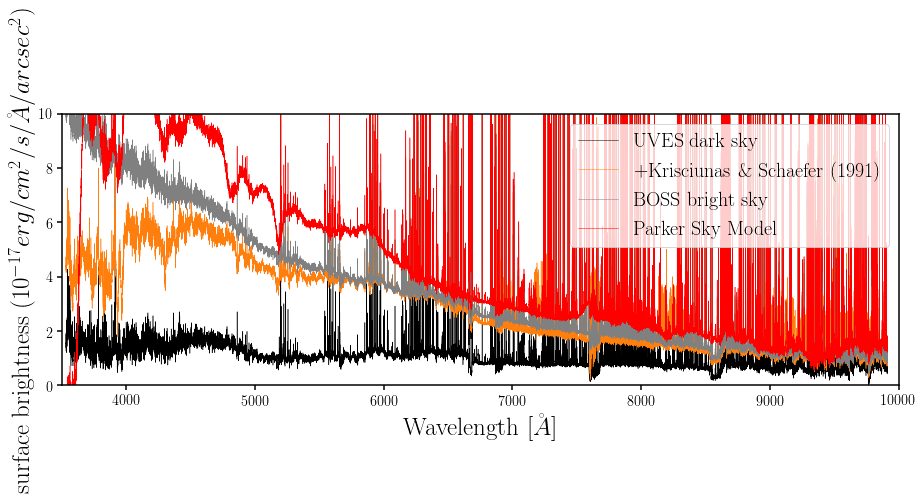

In [12]:
desi = FM.SimulatorHacked(config, num_fibers=1, camera_output=True)
airmass = 1.1
alt = 38.
sep = 120.
ill = 0.8
desi.atmosphere.airmass = airmass
desi.atmosphere.moon.moon_phase = np.arccos(2.*ill - 1)/np.pi #moon_phase/np.pi #np.arccos(2*moonfrac-1)/np.pi
desi.atmosphere.moon.moon_zenith = (90. - alt) * u.deg
desi.atmosphere.moon.separation_angle = sep * u.deg

theta_sky = (airmass, 30., 10., 180., 4.86761390e+09, -25., 150., np.arccos(2.*ill - 1), ill, sep, alt)
sky_obj = Sky.skySpec_manual(*theta_sky)
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(waves, surface_brightness_dict['dark'], 
         c='k', lw=0.5, label='UVES dark sky')
sub.plot(waves, surface_brightness_dict['dark'] + desi.atmosphere.moon.surface_brightness, 
         c='C1', lw=0.5, label=r'+Krisciunas $\&$ Schaefer (1991)')
sub.plot(waves, fakedesi._skySurfBright(waves, cond='bright'), 
         c='gray', lw=0.5, label='BOSS bright sky')
sub.plot(waves, sky_obj.surface_brightness(waves), 
         c='r', lw=0.5, label=r'Parker Sky Model')
sub.legend(loc='upper right', fontsize=20, frameon=True)
sub.set_xlabel(r'Wavelength [$\AA$]', fontsize=25)
sub.set_xlim([3500., 1.e4])
sub.set_ylabel(r"surface brightness ($10^{-17} erg/cm^{2}/s/\AA/arcsec^2$)", fontsize=25)
sub.set_ylim([0., 10.])

Above is the same comparison but for a less birght set of lunar parameters (_i.e._ low moon altitude, large moon separation): 
- airmass = `1.1`
- moon alt = `38.`
- moon sep = `120.`
- moon ill = `0.8`

2013-02-15 02:58:20


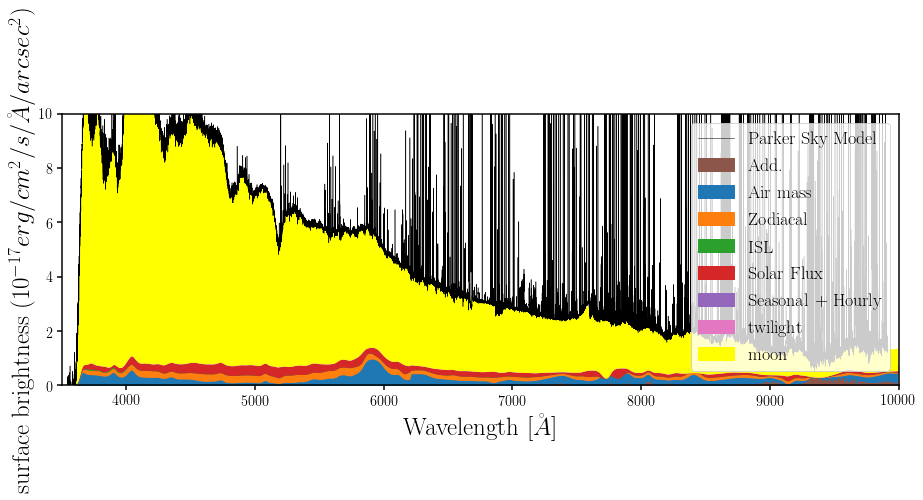

In [13]:
desi = FM.SimulatorHacked(config, num_fibers=1, camera_output=True)
airmass = 1.1
alt = 38.
sep = 120.
ill = 0.8
desi.atmosphere.airmass = airmass
desi.atmosphere.moon.moon_phase = np.arccos(2.*ill - 1)/np.pi #moon_phase/np.pi #np.arccos(2*moonfrac-1)/np.pi
desi.atmosphere.moon.moon_zenith = (90. - alt) * u.deg
desi.atmosphere.moon.separation_angle = sep * u.deg

theta_sky = (airmass, 30., 10., 180., 4.86761390e+09, -25., 150., np.arccos(2.*ill - 1), ill, sep, alt)
sky_obj = Sky.skySpec_manual(*theta_sky)
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(waves, sky_obj.surface_brightness(waves), 
         c='k', lw=0.5, label=r'Parker Sky Model')
wl_sort = np.argsort(np.array(sky_obj.coeffs['wl']))
ww = 10.*np.array(sky_obj.coeffs['wl'])[wl_sort]

Icont = (1./np.pi * sky_obj._dT * sky_obj._Iadd_continuum)
sub.fill_between(ww, np.zeros(len(wl_sort)), np.array(Icont)[wl_sort], color='C5', label='Add.')
Icont0 = np.array(Icont)[wl_sort]
Icont += (1./np.pi * sky_obj._dT * sky_obj._Iairmass)
sub.fill_between(ww, Icont0, np.array(Icont)[wl_sort], color='C0', label='Air mass')
Icont0 = np.array(Icont)[wl_sort]
Icont += (1./np.pi * sky_obj._dT * sky_obj._Izodiacal)
sub.fill_between(ww, Icont0, np.array(Icont)[wl_sort], color='C1', label='Zodiacal')
Icont0 = np.array(Icont)[wl_sort]
Icont += (1./np.pi * sky_obj._dT * sky_obj._Iisl)
sub.fill_between(ww, Icont0, np.array(Icont)[wl_sort], color='C2', label='ISL')
Icont0 = np.array(Icont)[wl_sort]
Icont += (1./np.pi * sky_obj._dT * sky_obj._Isolar_flux)
sub.fill_between(ww, Icont0, np.array(Icont)[wl_sort], color='C3', label='Solar Flux')
Icont0 = np.array(Icont)[wl_sort]
Icont += (1./np.pi * sky_obj._dT * (sky_obj._Iseasonal + sky_obj._Ihourly))
sub.fill_between(ww, Icont0, np.array(Icont)[wl_sort], color='C4', label='Seasonal + Hourly')
Icont0 = np.array(Icont)[wl_sort]
Icont += (1./np.pi * sky_obj._Itwilight)
sub.fill_between(ww, Icont0, np.array(Icont)[wl_sort], color='C6', label='twilight')
Icont0 = np.array(Icont)[wl_sort]
Icont += (1./np.pi * sky_obj._Imoon)
sub.fill_between(ww, Icont0, np.array(Icont)[wl_sort], color='yellow', label='moon')
sub.legend(loc='upper right', fontsize=18, frameon=True)
sub.set_xlabel(r'Wavelength [$\AA$]', fontsize=25)
sub.set_xlim([3500., 1.e4])
sub.set_ylabel(r"surface brightness ($10^{-17} erg/cm^{2}/s/\AA/arcsec^2$)", fontsize=25)
sub.set_ylim([0., 10.])

print sky_obj.obs_time.datetime

Here's the different contributions of the sky continuum